# Robust control design via loop shaping

**Dependencies**

In [1]:
from utils import *
from control.matlab import *

Define `s` to be the complex variable

In [2]:
s = tf("s")

## The plant

Define the nominal and real plant transfer functions:

**Nominal Plant**

$$
P_n = \frac{1}{s^2+2\hat{\xi}_p \omega_p s + \omega_p^2}
$$

In [3]:
wz, xiz = 4, 0.0
wp, xip = 1, 0.1
ws, xis = 7, 0

Pn = 1/((s**2+2*wp*xip*s+wp**2))
Pn.name = "$P_{n}$"

**Real plant**

$$    
P = \frac{\omega_s^2}{\omega_z^2} \left[\frac{1}{s^2+2\xi_p \omega_p s + \omega_p^2} \right]\left[\frac{s^2+2\xi_z \omega_z s+ \omega_z^2}{s^2+2\xi_s \omega_s s+ \omega_s^2}\right]
$$

In [4]:
xipr = 0.075
xizr = 0.002
xisr = 0.002

P = (ws**2/wz**2)*(s**2+2*xizr*wz*s+wz**2)/((s**2+2*wp*xipr*s+wp**2)*(s**2+2*xisr*ws*s+ws**2))
P.name = "$P$"

**Goal**

The nominal plant is our model of the plant, based on which we will design a controller. The real plant, however, has additional components that we have not accounted for in the nominal model. How do we design a controller based on the nominal plant, such that it is robust to these unmodeled components (when used with the real plant)?

### Frequency response of the plant

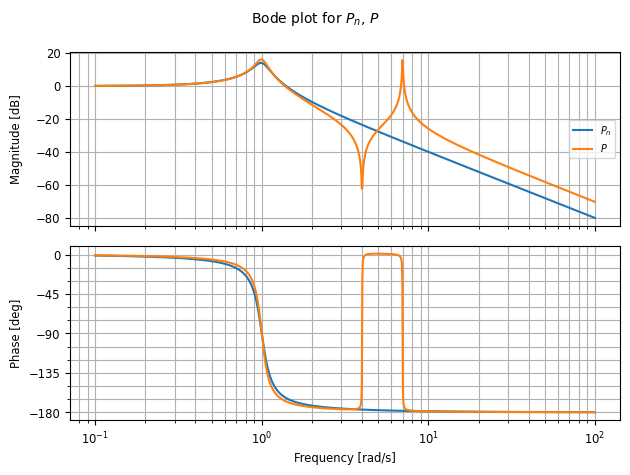

In [5]:
plt.figure(1)
bode(Pn, P)
plt.show()

## Control design

We first design the ideal loop transfer function, $L_i$, such that we have enough attenuation in the loop gain at the frequencies where we have unmodeled zero-pole pairs.

**Ideal loop transfer function**

$$
L_i  = \frac{1.4 kw_s^2}{s^2}\left[\frac{cs+1}{(bs+1)\left(\frac{b}{1.2}s+1\right)(s^2+0.4w_s s+ w_s^2)} \right] 
$$

In [6]:
wc = 0.3
r  = 0.3
k  = r*wc**2
A  = 3.1  #>2>r(A+r)>1
b  = np.sqrt(r*A+r**2-1)/wc
c  = np.sqrt(A/k)
ws = 1.4/b

Li = 1.4*(k*ws**2/s**2)*((c*s+1)/((b*s+1)*(b*s/1.2+1)*(s**2+2*0.2*ws*s+ws**2)))
Li.name = "$L_{i}$"

### Frequency response of the ideal loop transfer function

**Bode plot**

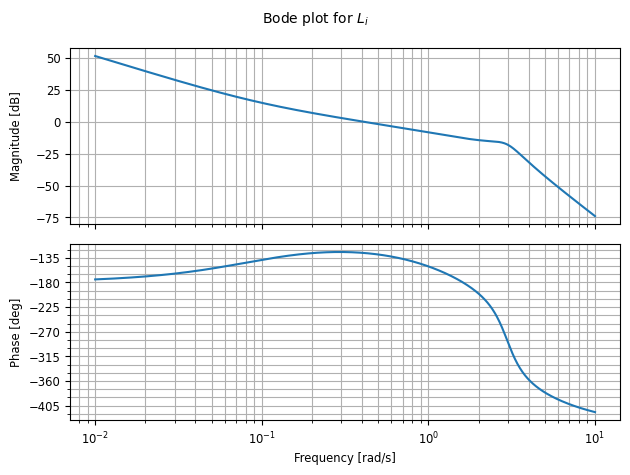

In [7]:
bode(Li)
plt.show()

**Gain margin and phase margin**

In [8]:
gm, pm, wcg, wcp = margin(Li)

print("\nGain  margin =  %.4f" % gm)
print("Phase margin = %.4f\n" % pm)


Gain  margin =  4.3595
Phase margin = 53.8700



**Nyquist plot**

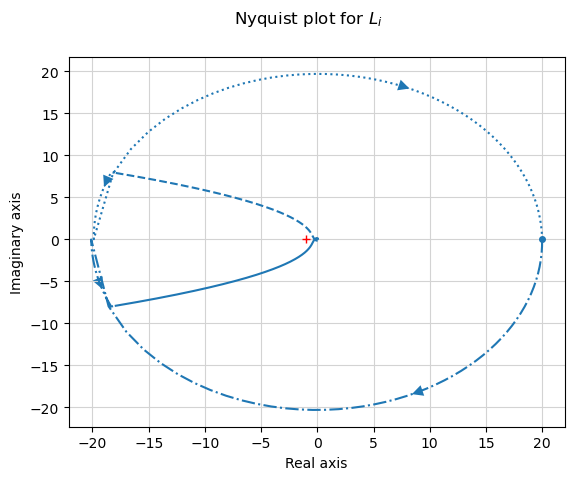

In [9]:
nyquist(Li)
plt.show()

**Nichols plot**

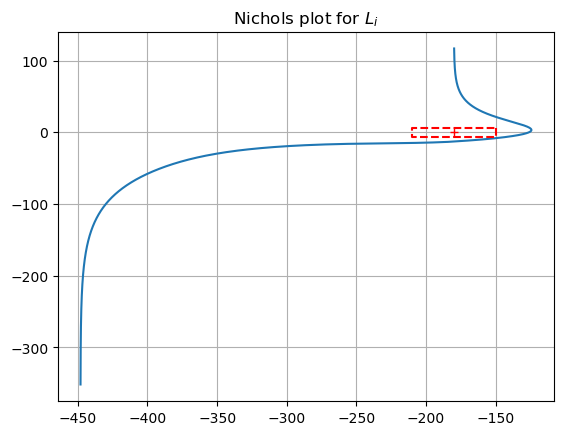

In [10]:
Liz = BfreqS(Li, 4) # defined in `utils.py`
plt.show()

## The controllers

We propose two controllers:
1. **Gain-stabilizing controller**: Since $L_i$ is designed such that we have enough attenuation in the loop gain at the frequencies where we have unmodeled zero-pole pairs, we can choose $C$ as follows (note that the controller is proper and hence realizable):
$$
C_1 = \frac{L_i}{P_n}
$$

In [11]:
C1 = Li/Pn # controller for gain stabilization

2. **Phase-stabilizing controller**: $C_2$ ensures stability with higher bandwidth. However, it requires accurate knowledge of phase due to the unmodeled zero-pole pairs. Otherwise, it may lead to instabilities or low phase margin and gain margin.
$$
C_2 =\frac{5s+1}{s(s+1)\left(\frac{s}{4}+1\right)}
$$

In [12]:
C2 = ((5*s+1)/s)*(s+1)/((1/4)*s+1) # controller for phase stabilization

Set $C$ to $C_1$ for gain stabilization or $C_2$ for phase stabilization below:

In [13]:
C = C1 # C1, C2

**Define the performance filter, $w_{P}$**

In [14]:
Mmax        = 2.5
Amin        = 1e-4
wbw         = 0.4

Wp          = (s/Mmax+wbw)/(s+wbw*Amin)
Wp_inv      = 1/Wp
Wp_inv.name = "$1 / w_{P}$"

**Loop transfer functions**

In [15]:
L           = C*P
L.name      = "$L$"

Ln          = C*Pn
Ln.name     = "$L_{n}$"

**Sensitivity transfer functions**

In [16]:
S           = 1/(1+L)
S.name      = "$S$"

Sn          = 1/(1+Ln)
Sn.name     = "$S_{n}$"

**Complementary sensitivity transfer functions**

In [17]:
T           = L*S
T.name      = "$T$"

Tn          = Ln*Sn
Tn.name     = "$T_{n}$"

**Gain margin and phase margin in the nominal and actual closed-loops**

In [18]:
gmn, pmn, wcgn, wcpn = margin(Ln)

print("\nGain  margin in the nominal closed-loop =  %.4f" % gmn)
print("Phase margin in the nominal closed-loop = %.4f\n" % pmn)

gmr, pmr, wcgr, wcpr = margin(L)

print("\nGain  margin in the actual closed-loop =  %.4f" % gmr)
print("Phase margin in the actual closed-loop = %.4f\n" % pmr)


Gain  margin in the nominal closed-loop =  4.3595
Phase margin in the nominal closed-loop = 53.8700


Gain  margin in the actual closed-loop =  4.6484
Phase margin in the actual closed-loop = 55.3206



**Maximum real parts of the poles of the nominal and actual closed-loops**

In [19]:
lamn          = np.roots(Sn.den[0][0])
lamn_max_real = np.max(np.real(lamn))
lam           = np.roots(S.den[0][0])
lam_max_real  = np.max(np.real(lam))

print("\nMaximum real part of the poles of the nominal closed-loop = %.4f" % lamn_max_real)
print("Maximum real part of the poles of the actual  closed-loop = %.4f\n" % lam_max_real)


Maximum real part of the poles of the nominal closed-loop = -0.1000
Maximum real part of the poles of the actual  closed-loop = -0.0201



### Frequency responses of the loop transfer functions

**Nyquist plots for the loop transfer functions**

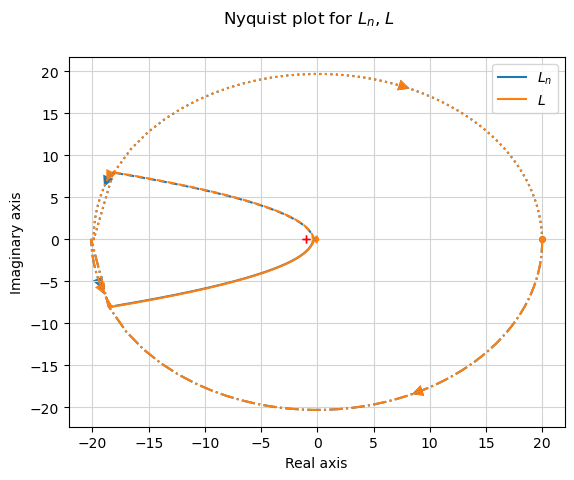

In [20]:
nyquist(Ln)
nyquist(L)
plt.show()

**Bode plots for the loop transfer functions**

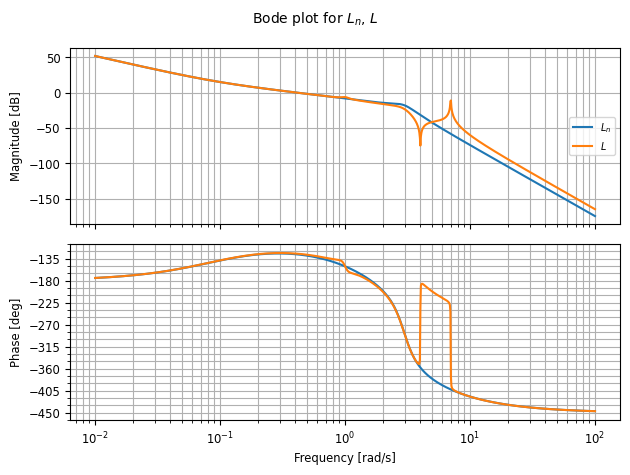

In [21]:
bode(Ln, L)
plt.show()

**Nichols plots for the loop transfer functions**

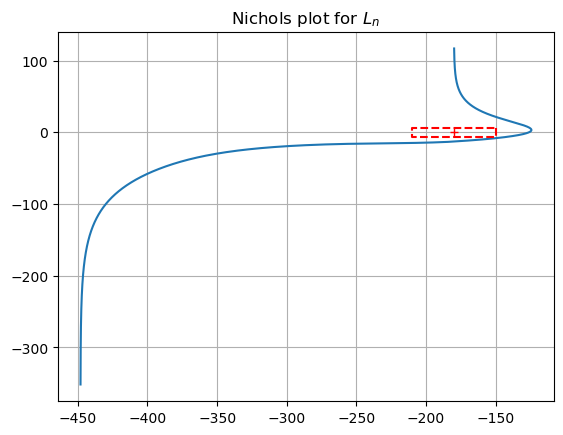

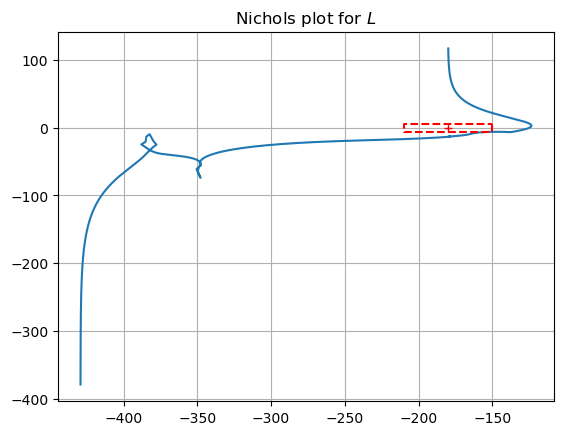

In [22]:
Lnz = BfreqS(Ln, 4)
Lz  = BfreqS(L, 4)

### Frequency responses of the closed-loop transfer functions

**Bode plots for the sensitivity transfer function and (the inverse of) its weighting transfer function**

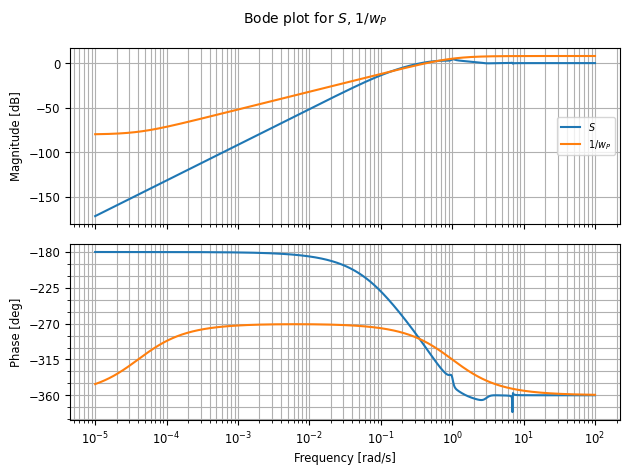

In [23]:
bode(S, Wp_inv)
plt.show()

**Bode plots for the nominal and actual complementary sensitivity (closed-loop) transfer functions**

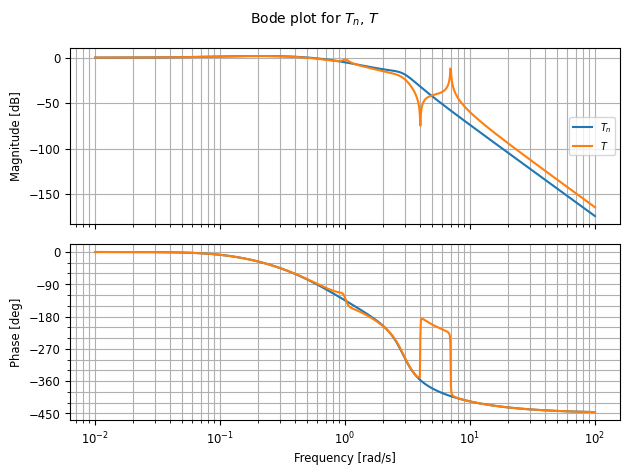

In [24]:
bode(Tn, T)
plt.show()